In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter


In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
images_directory = 'flickr8k/Images/'
# Path to the captions
captions_path = 'flickr8k/captions.txt'

In [23]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [24]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [25]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

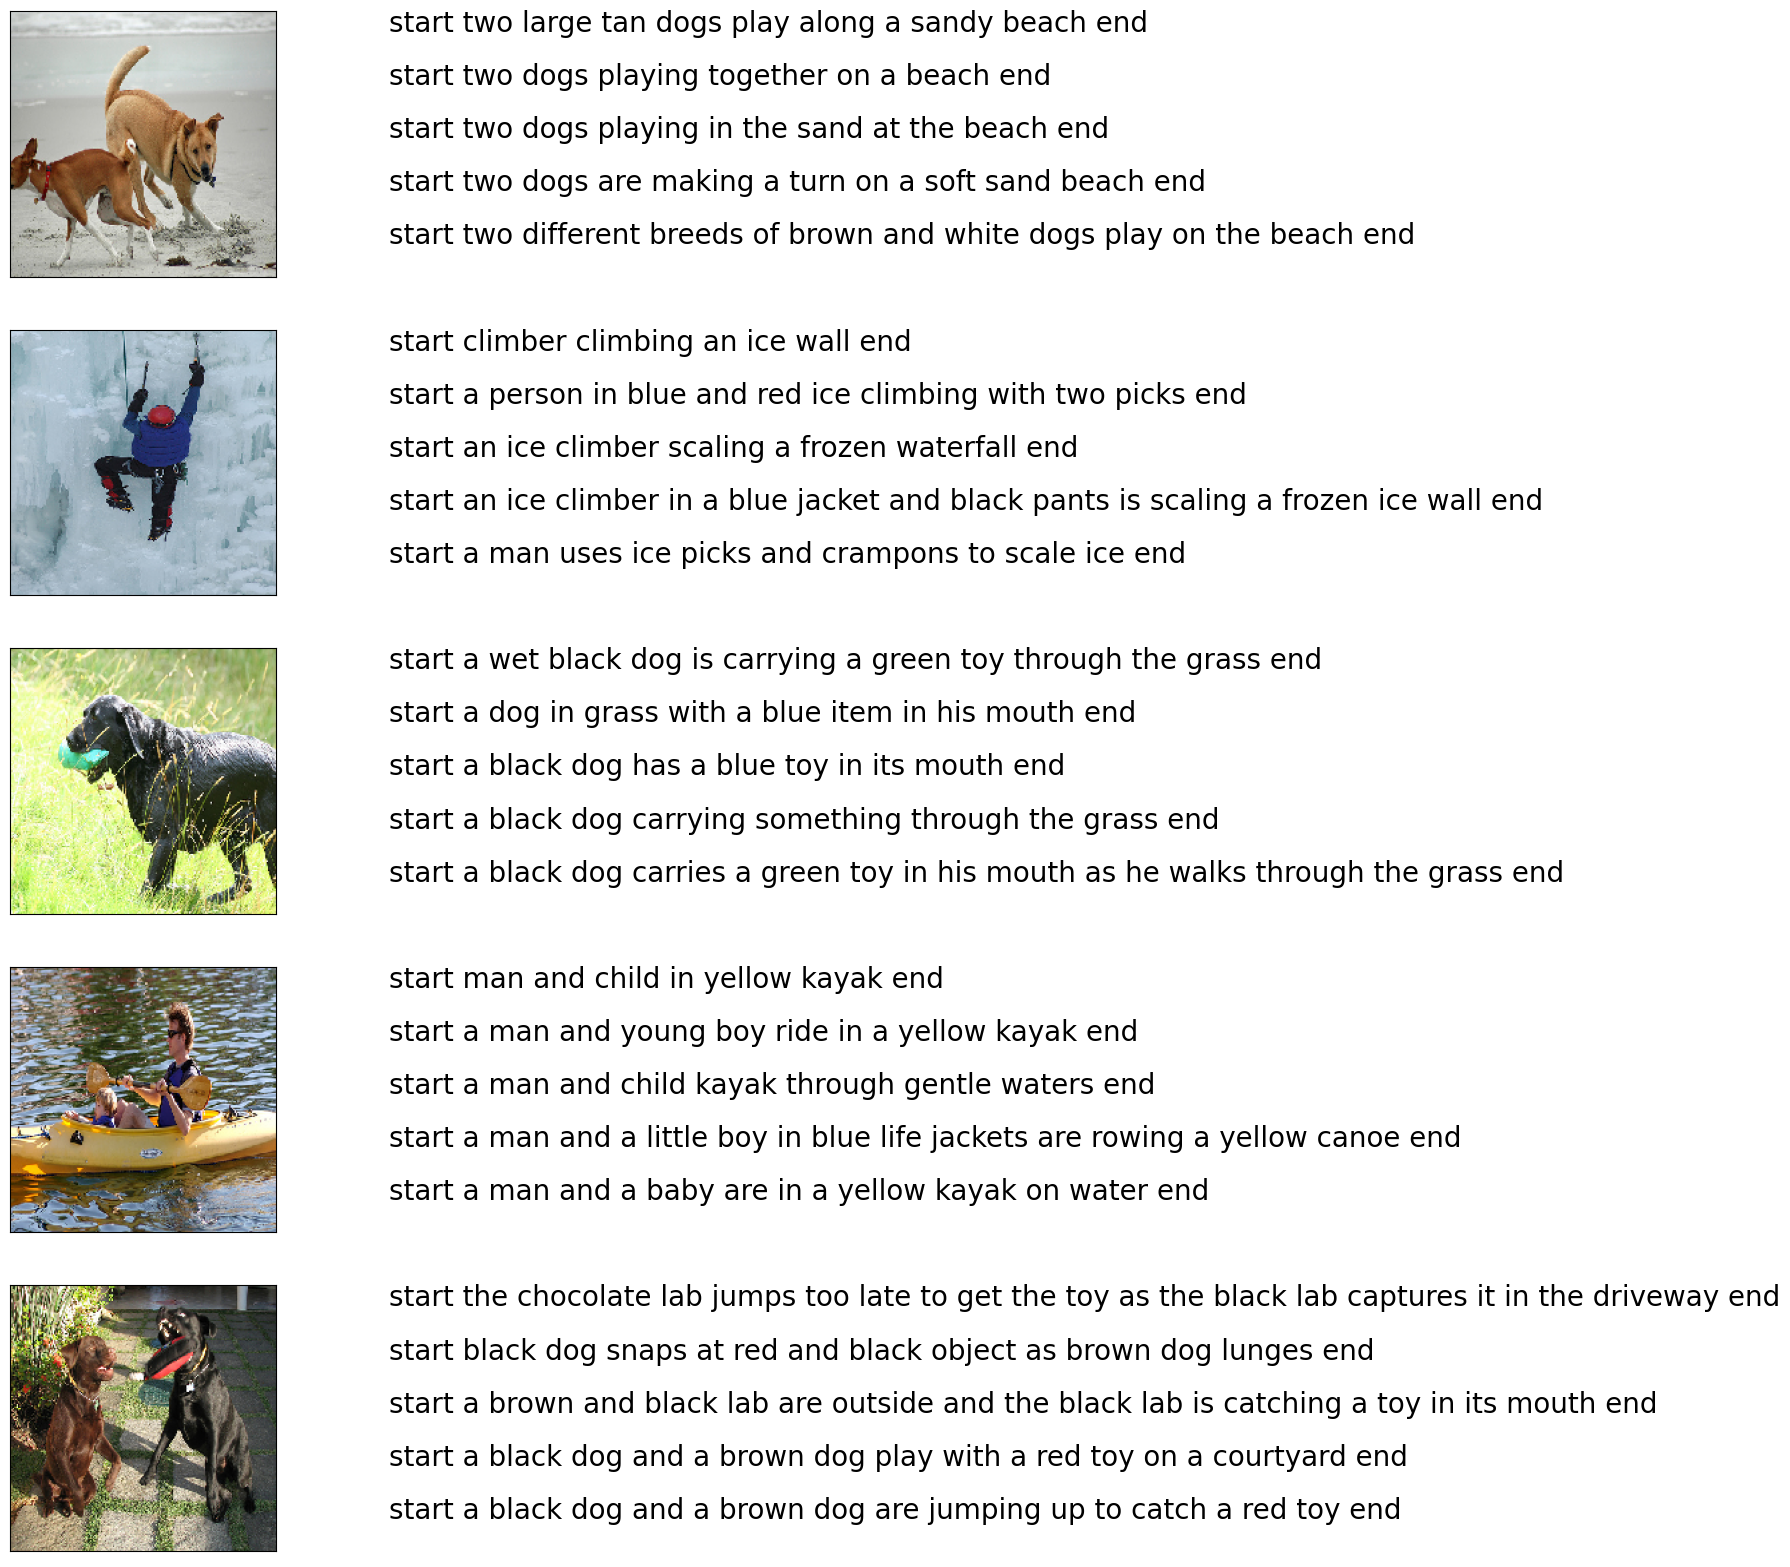

In [26]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
       captions = captions_dictionary[filename]
       image_load = load_img(images_directory+'/'+filename, target_size=(199,199,3))

       ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
       ax.imshow(image_load)
       count += 1

       ax = fig.add_subplot(num_of_images,2,count)
       plt.axis('off')
       ax.plot()
       ax.set_xlim(0,1)
       ax.set_ylim(0,len(captions))
       for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
       count += 1
    plt.show()

visualaization(captions_IDs, 5)


In [27]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [28]:
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1022454428_b6b660a67b.jpg\tstart a couple and an infant end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [29]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
with tf.device('/GPU:0'):
    inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
    inception_v3_model.layers.pop()
    inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

In [31]:
import os
import pickle
from tqdm.notebook import tqdm

# File paths for saved features
train_feat_file = "train_image_features.pkl"
val_feat_file = "val_image_features.pkl"
test_feat_file = "test_image_features.pkl"

# Check if features already exist
if os.path.exists(train_feat_file) and os.path.exists(val_feat_file) and os.path.exists(test_feat_file):
    print("✅ Loading precomputed features...")

    with open(train_feat_file, "rb") as f:
        train_image_features = pickle.load(f)
    with open(val_feat_file, "rb") as f:
        val_image_features = pickle.load(f)
    with open(test_feat_file, "rb") as f:
        test_image_features = pickle.load(f)

else:
    print("Extracting features")

    train_image_features, val_image_features, test_image_features = {}, {}, {}

    pbar = tqdm(total=len(all_image_ids), position=0, leave=True, colour='green')
    for caption in all_image_ids:
        image_id = caption.split('\t')[0]
        image_path = os.path.join(images_directory, image_id)
        image_features = extract_image_features(inception_v3_model, image_path)

        if image_id in train_image_ids:
            train_image_features[image_id] = image_features.flatten()
        elif image_id in val_image_ids:
            val_image_features[image_id] = image_features.flatten()
        elif image_id in test_image_ids:
            test_image_features[image_id] = image_features.flatten()
        else:
            print('Unknown image ID !')

        pbar.update(1)
    pbar.close()


✅ Loading precomputed features...


In [32]:
with open(train_feat_file, "wb") as f:
    pickle.dump(train_image_features, f, protocol=4)
with open(val_feat_file, "wb") as f:
    pickle.dump(val_image_features, f, protocol=4)
with open(test_feat_file, "wb") as f:
    pickle.dump(test_image_features, f, protocol=4)

print("✅ Features extracted and saved.")

✅ Features extracted and saved.


In [33]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (tf.constant(X_images, dtype=tf.float32), tf.constant(X_captions, dtype=tf.int32)), tf.constant(y, dtype=tf.float32)


# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 64
batch_size_val = 64

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

print("Max caption length:", max_caption_length)
print("Vocabulary size:", vocab_size)
print("CNN output dimension:", cnn_output_dim)

Max caption length: 34
Vocabulary size: 8586
CNN output dimension: 2048


In [34]:
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (807, 2048)
X_captions: (807, 34)
y: (807, 8586)
Validation sample batch shapes:
X_images: (772, 2048)
X_captions: (772, 34)
y: (772, 8586)


In [ ]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    # This Part of the code  converts the image feature vector to a suitable dimension from 2048->512->256
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(512, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(256, activation='relu')(fe3)
    fe5 = BatchNormalization()(fe4) # Final image feature vector of dimension 256
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256, return_sequences=True)(se1)
    se3 = LSTM(256)(se2)
    se4 = Dropout(0.5)(se3)

    # Output
    decoder1 = add([fe5, se4])
    decoder2 = Dense(256, activation='relu')(decoder1)
    decoder3 = Dropout(0.5)(decoder2)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder3)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_190 (Batch  (None, 2048)        8192        ['Features_Input[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 512)          1049088     ['batch_normalizat

In [36]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
# if os.path.exists('best_model_weights.h5'):
#     caption_model.load_weights('best_model_weights.h5')

#     print("Model weights loaded successfully.")

In [40]:
# ---------------------------------------------------------------------------------------------------------------------------------------
# Training the model with callbacks for early stopping, learning rate scheduling, and model checkpointing
# Commented out to avoid re-training and potential timeouts
# As Training already done
# ------------------------------------------------------------------------------------------------------------------------------------------

from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow as tf

# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

# Defining model checkpoint callback to save best model weights
model_checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, monitor='val_loss', mode='min')

# Creating TensorFlow Datasets from the generators with explicit output_signature
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train),
    output_signature=(
        (tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val),
    output_signature=(
        (tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)


history = caption_model.fit(train_dataset, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_dataset, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule, model_checkpoint])

Epoch 1/15
537/537 [==============================] - 635s 1s/step - loss: 4.5504 - val_loss: 3.8826 - lr: 0.0030
Epoch 2/15
537/537 [==============================] - 798s 1s/step - loss: 3.9132 - val_loss: 3.6189 - lr: 0.0017
Epoch 3/15
537/537 [==============================] - 985s 2s/step - loss: 3.6740 - val_loss: 3.5025 - lr: 9.0718e-04
Epoch 4/15
537/537 [==============================] - 746s 1s/step - loss: 3.5482 - val_loss: 3.4378 - lr: 4.9787e-04
Epoch 5/15
537/537 [==============================] - 618s 1s/step - loss: 3.4740 - val_loss: 3.4078 - lr: 2.7324e-04
Epoch 6/15
537/537 [==============================] - 628s 1s/step - loss: 3.4325 - val_loss: 3.3944 - lr: 1.4996e-04
Epoch 7/15
537/537 [==============================] - 643s 1s/step - loss: 3.4086 - val_loss: 3.3873 - lr: 8.2297e-05
Epoch 8/15
537/537 [==============================] - 607s 1s/step - loss: 3.3912 - val_loss: 3.3826 - lr: 4.5166e-05
Epoch 9/15
537/537 [==============================] - 580s 1s/st

In [41]:
with open('best_model_weights.h5', 'wb') as f:
    pickle.dump(history.history, f)

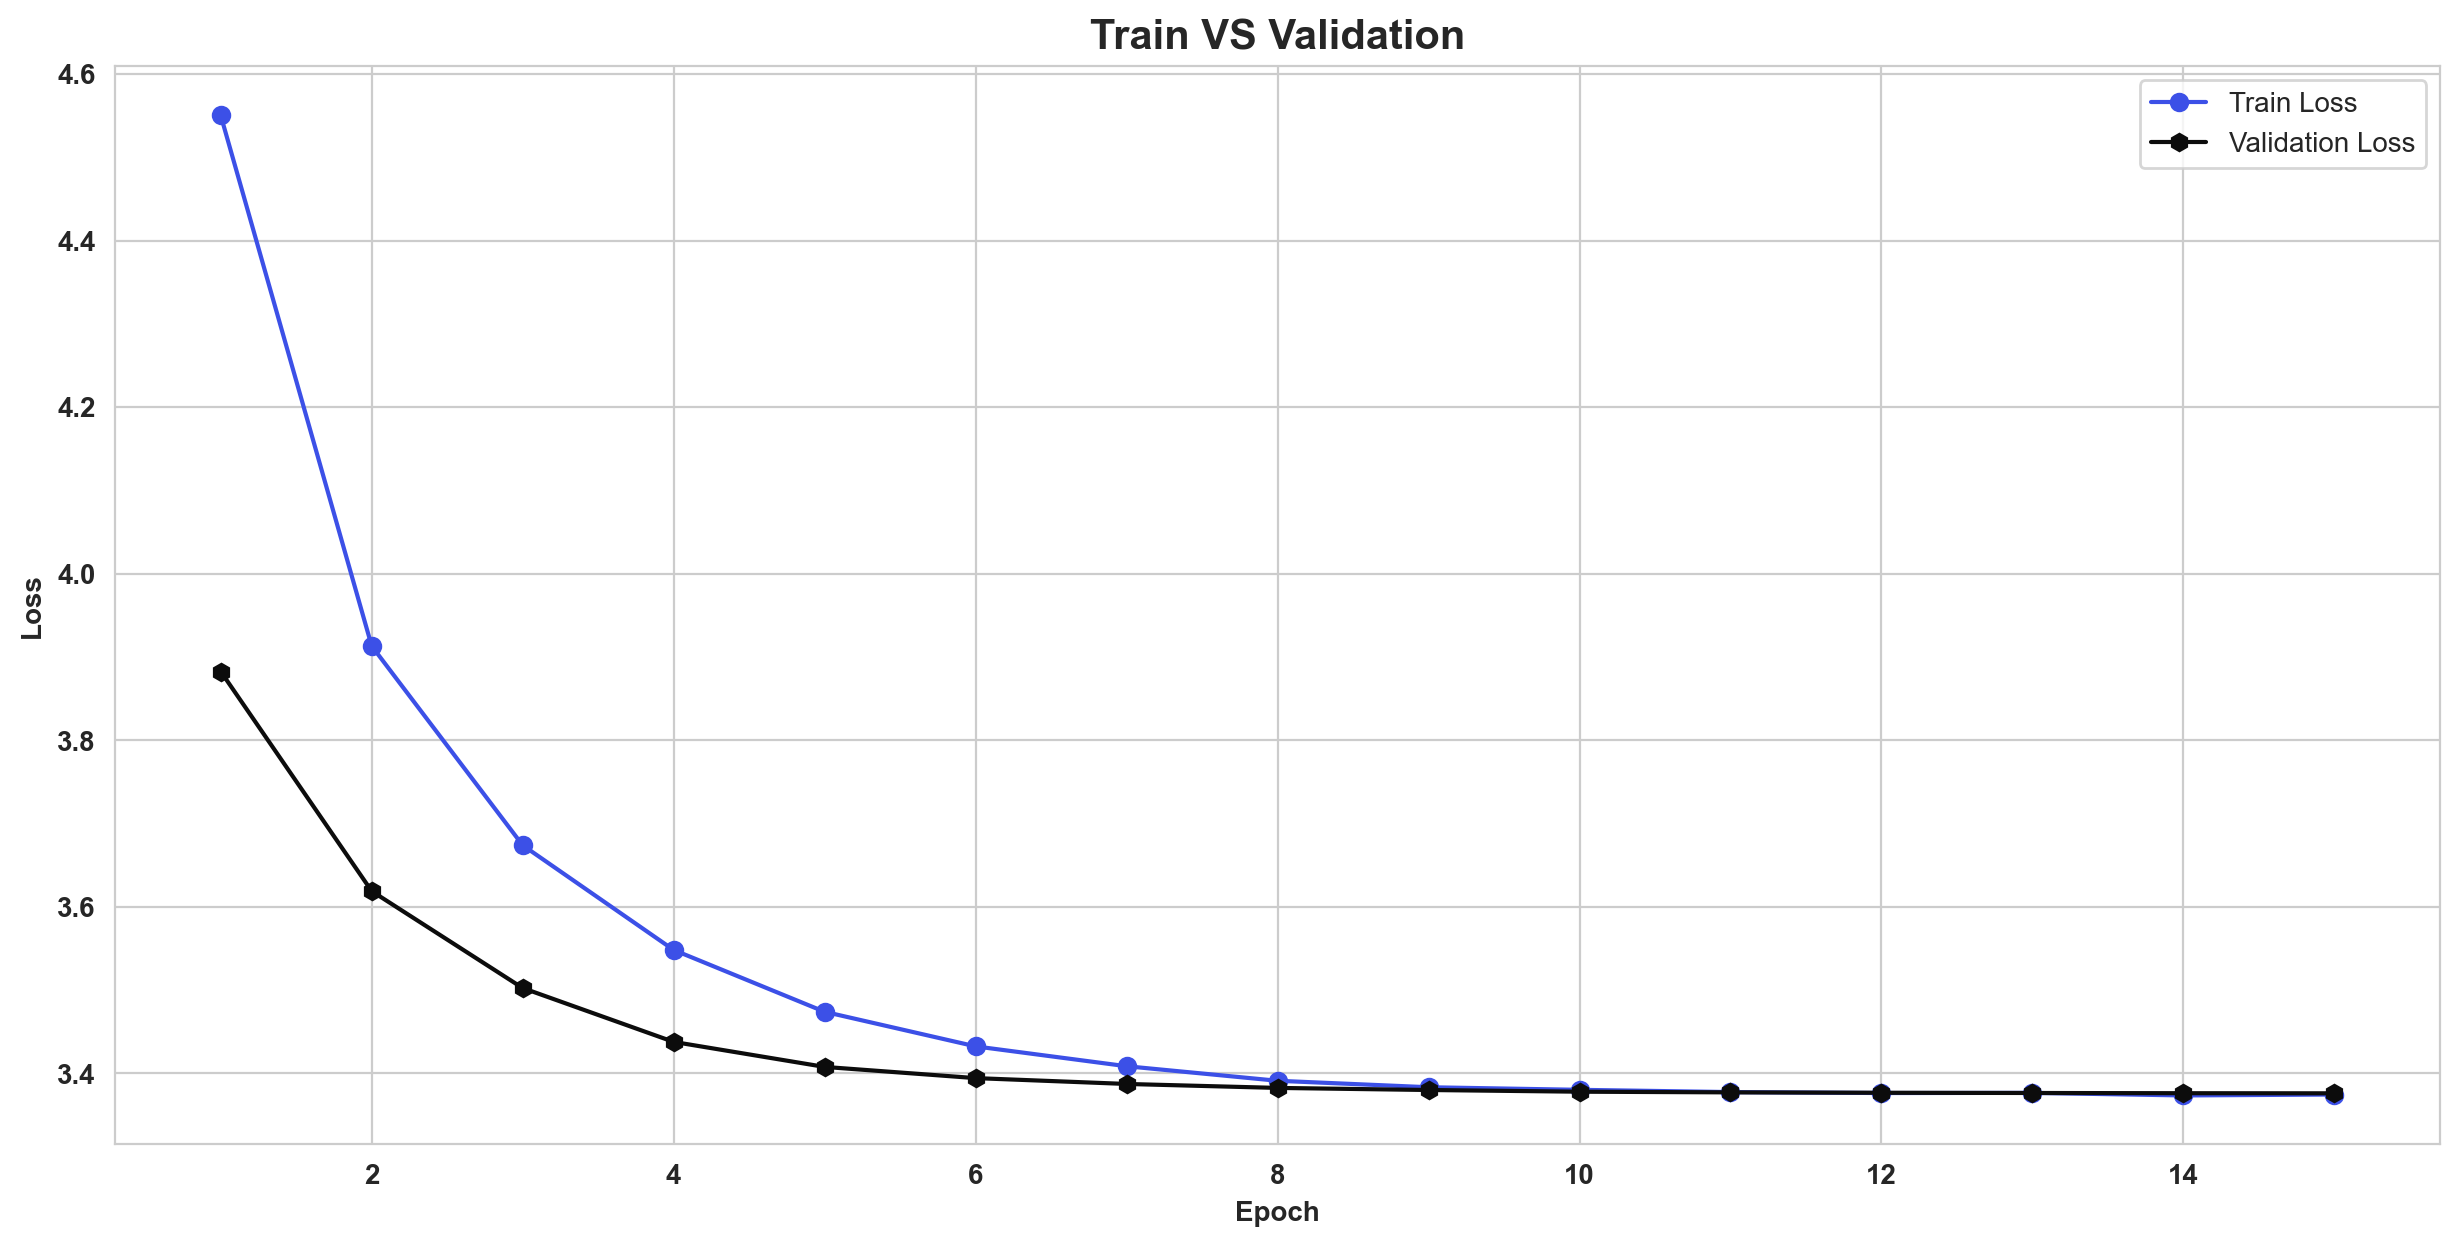

In [42]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color="#3C50E7", marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color="#0C0C0C", marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [43]:
def greedy_generator(image_features):  
    # Each caption is started with the word 'start'
    in_text = 'start'
    
    for _ in range(max_caption_length):
        # Convert current text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        
        # Predict next word
        prediction = caption_model.predict(
            [image_features.reshape(1, cnn_output_dim), sequence],
            verbose=0
        )
        idx = np.argmax(prediction)

        # Handle padding/unknown predictions safely
        if idx == 0:   # skip <PAD>
            continue
        word = tokenizer.index_word.get(idx, "<UNK>")

        # Add predicted word
        in_text += ' ' + word

        # Stop if 'end' token is generated
        if word == 'end':
            break

    # Clean special tokens
    in_text = in_text.replace('start ', '', 1)  # remove only first 'start'
    in_text = in_text.replace(' end', '')

    return in_text


In [44]:
def beam_search_generator(image_features, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]

    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Prepare sequence
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))

            preds = caption_model.predict(
                [image_features.reshape(1, cnn_output_dim), sequence],
                verbose=0
            )

            # Top K predictions
            word_preds = np.argsort(preds[0])[-K_beams:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w] + 1e-10)  # safe log
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        # Sort beams by probability
        start_word = sorted(temp, key=lambda l: l[1])
        start_word = start_word[-K_beams:]  # keep top beams

    # Best sequence
    best_seq = start_word[-1][0]

    # Map IDs → words safely
    captions_ = [
        tokenizer.index_word.get(int(i), "<UNK>")
        for i in best_seq
        if int(i) != 0  # skip <PAD>
    ]

    # Build final caption (remove 'start', stop at 'end')
    final_caption = []
    for w in captions_:
        if w == 'end':
            break
        if w not in ['start', '<PAD>']:
            final_caption.append(w)

    return ' '.join(final_caption)


In [45]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [46]:
    # Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
  cap = greedy_generator(test_image_features[image_id])
  generated_captions[image_id] = cap
  pbar.update(1)

pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

In [48]:

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def BLEU_score(actual, greedy, beam_search):
    smoothie = SmoothingFunction().method4
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(1.0, 0, 0, 0),smoothing_function=smoothie)
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(1.0, 0, 0, 0),smoothing_function=smoothie)
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

    scores = [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

    return scores

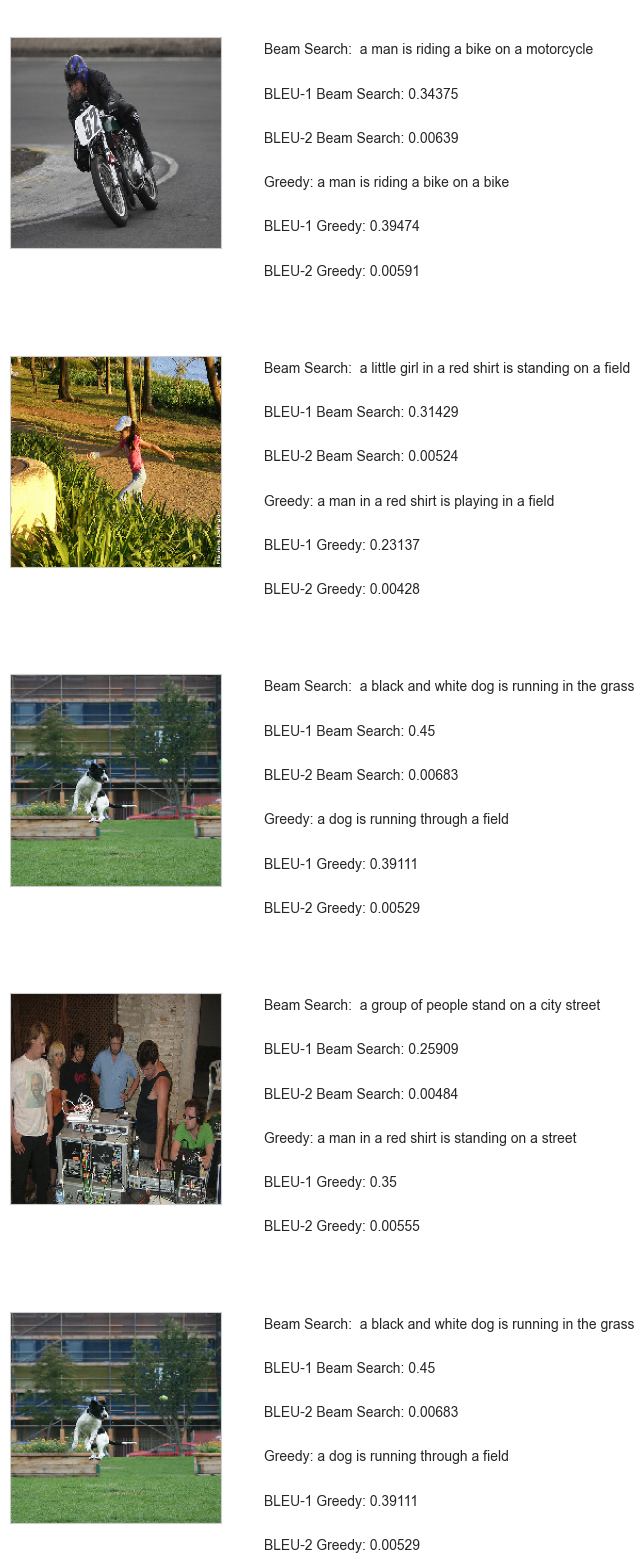

In [50]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token
        
        # Generating captions
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])
        
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))
    
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 5)

In [49]:
import random
from nltk.translate.bleu_score import corpus_bleu
from sklearn.metrics import precision_score, recall_score, f1_score

# Build ground-truth dictionary
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption.strip())

# Randomly sample 500 test images
sampled_image_ids = random.sample(list(test_image_features.keys()), min(500, len(test_image_features)))

generated_captions = {}
actual_list, predicted_list = [], []

pbar = tqdm_notebook(total=len(sampled_image_ids), position=0, leave=True, colour='green')
for image_id in sampled_image_ids:
    features = test_image_features[image_id]
    gen_caption = greedy_generator(features)

    generated_captions[image_id] = gen_caption

    # For BLEU
    actual_list.append([c.split() for c in test_actual_captions[image_id]])
    predicted_list.append(gen_caption.split())

    pbar.update(1)
pbar.close()

# =======================
# BLEU-1
# =======================
bleu1 = corpus_bleu(actual_list, predicted_list, weights=(1.0, 0, 0, 0))

# =======================
# Precision, Recall, F1
# =======================
all_actual_words = []
all_predicted_words = []

for refs, pred in zip(actual_list, predicted_list):
    ref_words = set([w for r in refs for w in r])
    pred_words = set(pred)

    for word in ref_words.union(pred_words):
        all_actual_words.append(1 if word in ref_words else 0)
        all_predicted_words.append(1 if word in pred_words else 0)

precision = precision_score(all_actual_words, all_predicted_words)

# =======================
# Print results
# =======================
print("✅ Evaluation Results on 500 random test images:")
print(f"BLEU-1:   {bleu1:.4f}")
print(f"Precision:{precision:.4f}")


  0%|          | 0/122 [00:00<?, ?it/s]

✅ Evaluation Results on 500 random test images:
BLEU-1:   0.5473
Precision:0.5466
